<h2 style = 'color: blue'> Auto Encoders <h2>


In this notebook, we start by implementing a vanilla AutoEncoder and then modify it to learn the distribution of the input instead of its features. The actual meaning of the features is determined and learned by the model as it processes the inputs and their corresponding outputs. Then we will make it convolutional and compare the results.

In [6]:
''' Import required libraries '''

import torch
from torch.utils.data import random_split, DataLoader
import random
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

<h4 style = 'color: green'> First we explore the dataset <h4>


In [3]:
batch_size = 64

t = transforms.Compose([
    transforms.ToTensor()
])

data = datasets.MNIST(root='mnist/', download=True, transform=t)
train, test = random_split(data, [50000, 10000])

train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle= True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.19MB/s]


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



Visualize some random samples from the dataset

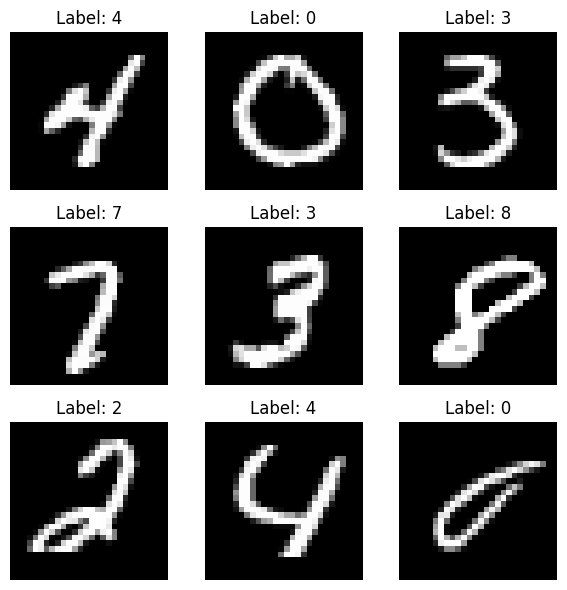

In [7]:
''' visualization '''

def display_random_images(data_loader):
    batch = next(iter(data_loader))
    imgs, lbls = batch

    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    for ax, img, lbl in zip(axes.flatten(), imgs, lbls):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'Label: {lbl.item()}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

display_random_images(train_loader)

<img  style = "height: 500px; display: flex; justify-content: center;" src = 'https://b2633864.smushcdn.com/2633864/wp-content/uploads/2023/07/vanilla-AE.png?size=630x472&lossy=2&strip=1&webp=1'>


Imagine we have a 28x28 pixel image. We save n features of this image, and later, we can reconstruct the image using just these features. There's a magical machine that knows how to extract these n features from the original image, and another machine that knows how to reconstruct the image based on those features. When training an AutoEncoder, these two machines, called the encoder and decoder, learn how to perform these operations.

The encoder learns how to compress the image into a smaller feature space, while the decoder learns how to reconstruct the original image from this compressed representation.

<h4 style = 'color: green'> Here you implement an AutoEncoder <h4>


In [8]:
''' AutoEncoder class '''

class AE(torch.nn.Module):
    def __init__(self, input_size, hidden_size, feature_size):
        super(AE, self).__init__()

        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Flatten(),
            torch.nn.Linear(32*7*7, hidden_size),
            torch.nn.ReLU()
        )

        # Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, 32*7*7),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (32, 7, 7)),
            torch.nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



Before we start training and evaluation, let's implement a variation of this model. During inference, in the traditional AutoEncoder, each image is mapped to a fixed vector of features, and the model is strict about this exact representation. Instead of using fixed numbers, we can keep a distribution, allowing for smoother interpolation in the feature space.

To achieve this, we introduce two vectors for each image: one representing the mean, and the other representing the log of the variance. Both vectors have the same size as the original feature space. In other words, we now have the parameters required to define a unique normal distribution for each image.

<img  style = "height: 500px; display: flex; justify-content: center;" src = 'https://github.com/bvezilic/Variational-autoencoder/raw/master/assets/VAE.001.jpeg'>


During decoding, instead of using a fixed feature vector, we sample from this distribution to build the features. This makes our model more flexible and generative, allowing it to create variations of images similar to those in the training dataset.

<div style="color: orange;">
  <h3>Now you might ask two questions:</h3>
  <ul>
    <li>Why do we keep the logarithm of the variance instead of the standard deviation?</li>
    <p>In short, it's due to numerical instability. If you're not convinced, you can check
      <a href="https://stats.stackexchange.com/questions/353220/why-in-variational-auto-encoder-gaussian-variational-family-we-model-log-sig" style="color: blue;">here</a>.
    </p>
    <li>How and where do we reparameterize?</li>
    <p>All you need to do during reparameterization is to compute the standard deviation using the formula:</p>
    <p style="font-weight: bold; text-align: center;">std = e<sup>0.5 * logvar</sup></p>
    <p>This can be implemented in the reparameterization function within the class below.</p>
  
  </ul>
</div>


<h4 style = 'color: green'> Now you implement a Variational AutoEncoder <h4>


In [14]:
''' Variational AutoEncoder class '''



class VAE(AE):
    def __init__(self, input_size, hidden_size, feature_size):
        super(VAE, self).__init__(input_size, hidden_size, feature_size)

        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, feature_size),
        )

        self.fc_mu = nn.Linear(feature_size, feature_size)
        self.fc_logvar = nn.Linear(feature_size, feature_size)

        self.decoder = nn.Sequential(
            nn.Linear(feature_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5 * logVar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, x):
        h = self.encoder(x)
        mu, logVar = self.fc_mu(h), self.fc_logvar(h)
        z = self.reparameterize(mu, logVar)
        return self.decoder(z), mu, logVar

    def loss_function(self, recon_x, x, mu, logVar):
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + logVar - mu.pow(2) - logVar.exp())
        return recon_loss + kl_div



<h4 style = 'color: green'> Here, we first train the AE and then the VAE <h4>


Epoch [1/10], Loss: 0.035816876495214145
Epoch [2/10], Loss: 0.01109431177208586
Epoch [3/10], Loss: 0.008242531157339283
Epoch [4/10], Loss: 0.006958241823374692
Epoch [5/10], Loss: 0.006143183551628685
Epoch [6/10], Loss: 0.005596003530885253
Epoch [7/10], Loss: 0.0051577996356589025
Epoch [8/10], Loss: 0.004817108321777733
Epoch [9/10], Loss: 0.0045445354371343545
Epoch [10/10], Loss: 0.004320219299658333


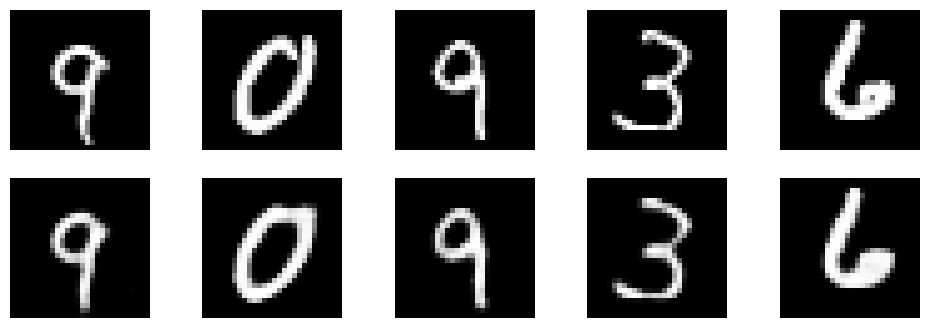

In [10]:
''' Train loop for AE '''

lr = 1e-3
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loader = DataLoader(dataset=test, batch_size=batch_size, shuffle=False)
model = AE(input_size=784, hidden_size=128, feature_size=784).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)

        optimizer.zero_grad()


        outputs = model(images)


        loss = loss_fn(outputs, images)


        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")


visualize_reconstruction(model, test_loader)


Implement a function that takes the model and the number of images as inputs, samples random images from your test dataset, and displays both the original and reconstructed images.

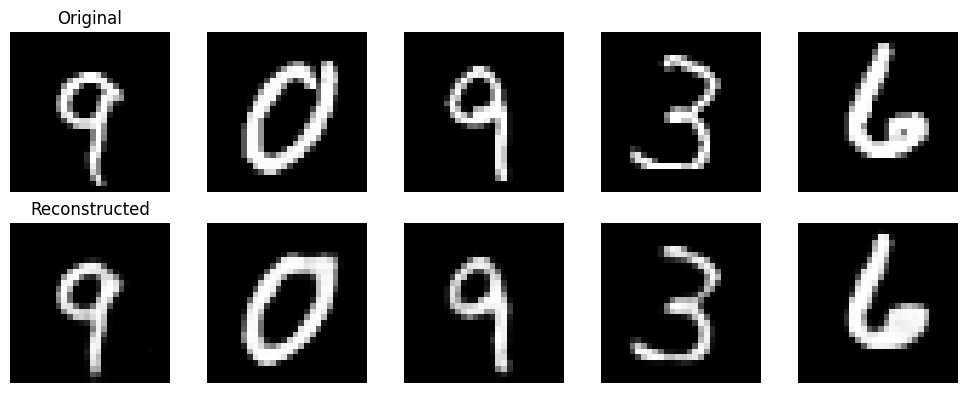

In [11]:
''' evaluation '''
def visualize_reconstruction(model, data_loader, num_images=5):
    model.eval()

    with torch.no_grad():
        images, _ = next(iter(data_loader))
        images = images.to(device)

        reconstructed = model(images)

    images = images.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

    for i in range(num_images):
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')

    axes[0, 0].set_title("Original")
    axes[1, 0].set_title("Reconstructed")

    plt.tight_layout()
    plt.show()

visualize_reconstruction(model, test_loader, num_images=5)



<h4 style = 'color: green'> Now we do exactly the same but this time for the VAE <h4>


Here, KL is a good choice, so we consider this loss with the proper weight in our training loop.

The KL (Kullback-Leibler) loss measures the difference between two probability distributions. In Variational Autoencoders (VAEs), KL loss ensures that the learned latent space follows a standard normal distribution.

The formula for KL loss is:

$
\text{KL}(q(z \mid x) \| p(z)) = -\frac{1}{2} \sum \left( 1 + \log(\sigma^2) - \mu^2 - \sigma^2 \right)
$


In [17]:
''' Train loop for VAE '''




lr = 1e-3
epochs = 10
input_dim = 28 * 28
hidden_dim = 128
latent_dim = 64

vae = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=lr)
mse = nn.MSELoss()

print("Training VAE...")
for epoch in range(epochs):
    vae.train()
    total_loss, rec_loss, kl_div = 0, 0, 0

    for batch, (x, _) in enumerate(train_loader):
        x = x.view(x.size(0), -1)

        x_recon, mu, log_var = vae(x)

        rec_err = mse(x_recon, x)
        kl_err = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = rec_err + kl_err

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        rec_loss += rec_err.item()
        kl_div += kl_err.item()

    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Loss: {total_loss/len(train_loader):.4f}, "
          f"Reconstruction: {rec_loss/len(train_loader):.4f}, "
          f"KL: {kl_div/len(train_loader):.4f}")


Training VAE...
Epoch [1/10] - Loss: 0.3014, Reconstruction: 0.0733, KL: 0.2281
Epoch [2/10] - Loss: 0.0678, Reconstruction: 0.0677, KL: 0.0002
Epoch [3/10] - Loss: 0.0676, Reconstruction: 0.0676, KL: 0.0000
Epoch [4/10] - Loss: 0.0675, Reconstruction: 0.0675, KL: 0.0000
Epoch [5/10] - Loss: 0.0675, Reconstruction: 0.0675, KL: 0.0000
Epoch [6/10] - Loss: 0.0675, Reconstruction: 0.0675, KL: 0.0000
Epoch [7/10] - Loss: 0.0675, Reconstruction: 0.0675, KL: 0.0000
Epoch [8/10] - Loss: 0.0675, Reconstruction: 0.0675, KL: 0.0000
Epoch [9/10] - Loss: 0.0674, Reconstruction: 0.0674, KL: 0.0000
Epoch [10/10] - Loss: 0.0675, Reconstruction: 0.0674, KL: 0.0000


Same as you did, compare the constructed images and original ones but this time with the VAE model

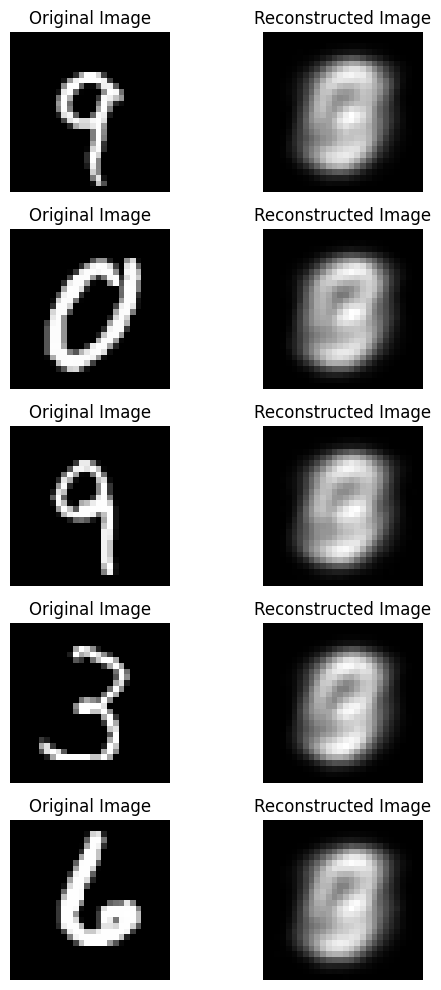

In [38]:
''' evaluation '''
import torch
import numpy as np
import matplotlib.pyplot as plt

def evaluate_vae(model, test_loader, num_images=5):
    model.eval()

    images = []
    reconstructed_images = []

    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            if i * data.size(0) >= num_images:
                break

            data = data.view(data.size(0), -1)


            reconstructed, mu, logVar = model(data)


            images.append(data[:num_images].cpu().numpy())
            reconstructed_images.append(reconstructed[:num_images].cpu().numpy())


    images = np.concatenate(images, axis=0)
    reconstructed_images = np.concatenate(reconstructed_images, axis=0)


    fig, axes = plt.subplots(num_images, 2, figsize=(6, num_images * 2))
    for i in range(num_images):

        ax = axes[i, 0]
        ax.imshow(images[i].reshape(28, 28), cmap='gray')
        ax.set_title("Original Image")
        ax.axis('off')


        ax = axes[i, 1]
        ax.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        ax.set_title("Reconstructed Image")
        ax.axis('off')

    plt.tight_layout()
    plt.show()
evaluate_vae(vae, test_loader, num_images=5)


This time, we modify the VAE to process the input using convolutional layers. Implement a convolutional VAE with an architecture of your choice, but keep it as simple as possible.

In [26]:


import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNVAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(CNNVAE, self).__init__()

        self.encoder_conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.encoder_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.encoder_fc = nn.Linear(64 * 7 * 7, 256)

        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        self.decoder_fc = nn.Linear(latent_dim, 256)
        self.decoder_fc2 = nn.Linear(256, 64 * 7 * 7)

        self.decoder_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_conv2 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = F.relu(self.encoder_conv1(x))
        x = F.relu(self.encoder_conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.encoder_fc(x))

        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)

        x = F.relu(self.decoder_fc(z))
        x = F.relu(self.decoder_fc2(x))
        x = x.view(-1, 64, 7, 7)

        x = F.relu(self.decoder_conv1(x))
        x = torch.sigmoid(self.decoder_conv2(x))

        return x, mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        bce = F.binary_cross_entropy(recon_x.view(-1, 28 * 28), x.view(-1, 28 * 28), reduction='sum')
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return bce + kl




Train your convolutional VAE model (same as you did for VAE)

In [27]:
''' Train loop '''



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNVAE(latent_dim=10).to(device)

lr = 1e-3
epochs = 30
optimizer = optim.Adam(model.parameters(), lr=lr)
mse_loss = torch.nn.MSELoss()

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for data, _ in train_loader:
        data = data.to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = mse_loss(recon_batch, data.view(recon_batch.size()))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.15f}')



Epoch [1/30], Loss: 0.000326235034596
Epoch [2/30], Loss: 0.000141172000642
Epoch [3/30], Loss: 0.000122401300895
Epoch [4/30], Loss: 0.000113554033544
Epoch [5/30], Loss: 0.000107789143097
Epoch [6/30], Loss: 0.000103623720693
Epoch [7/30], Loss: 0.000100212069896
Epoch [8/30], Loss: 0.000097180379322
Epoch [9/30], Loss: 0.000094853139870
Epoch [10/30], Loss: 0.000092654889527
Epoch [11/30], Loss: 0.000090729503520
Epoch [12/30], Loss: 0.000089220770433
Epoch [13/30], Loss: 0.000087526843930
Epoch [14/30], Loss: 0.000086321403490
Epoch [15/30], Loss: 0.000085186269615
Epoch [16/30], Loss: 0.000084146560418
Epoch [17/30], Loss: 0.000083052444722
Epoch [18/30], Loss: 0.000082089631027
Epoch [19/30], Loss: 0.000081334334255
Epoch [20/30], Loss: 0.000080643354155
Epoch [21/30], Loss: 0.000079834787423
Epoch [22/30], Loss: 0.000079193171176
Epoch [23/30], Loss: 0.000078564127985
Epoch [24/30], Loss: 0.000077913104386
Epoch [25/30], Loss: 0.000077344734206
Epoch [26/30], Loss: 0.00007686739

Compare the reconstructed and original images as you did before, but for the model you have just trained

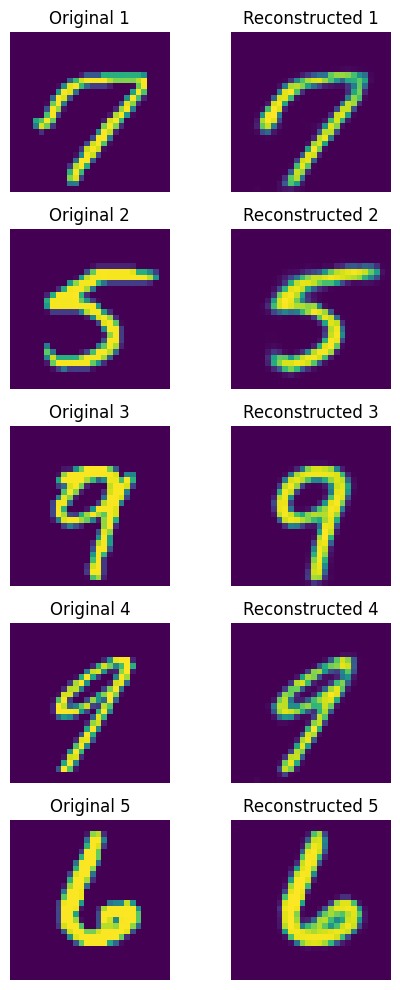

In [28]:
''' evaluation '''



def evaluate(model, test_loader, num_images=5):
    model.eval()

    images, _ = next(iter(test_loader))
    indices = torch.randint(0, images.size(0), (num_images,))
    selected_images = images[indices].to(device)

    with torch.no_grad():
        recon_images, _, _ = model(selected_images)

    fig, axes = plt.subplots(num_images, 2, figsize=(5, num_images * 2))

    for i in range(num_images):
        axes[i, 0].imshow(selected_images[i].cpu().numpy().transpose(1, 2, 0))
        axes[i, 0].set_title(f"Original {i+1}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(recon_images[i].cpu().numpy().transpose(1, 2, 0))
        axes[i, 1].set_title(f"Reconstructed {i+1}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

evaluate(model, test_loader, num_images=5)

